In [1]:
import sys
sys.path.append('..') #to add top-level to path

from modules.project_helper import TweetData, FuturesCloseData
import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Tweet Returns Features

With this feature,  we try to model the 'return' of every tweet. We look at all tweets in a day, from market close to market close, and observe the one day return for every instrument. We attribute every word tweeted that day these returns, and calculate the cumulative mean returns, or the score, for every word for every day for every asset. 

To achieve this, we need to create a dataframe for every asset, with every word in Trumps corpus in the index, and the corresponding return of each word.  I clipped the return to be at most 0.5% per day,, in either direction, so that days with very strong moves didn't end up dominating the signal.

After obtaining the returns for each word, we calculate mean cumulative returns for each word, for each day, so we have a measure of each word's return up to a particular day. 

Now we can average the returns of all words in every individual tweet, or in all tweets in a single day. We consider only days where he tweeted more than 10 words to avoid noise of single word returns.

From here we have three features: 

- daily_tweet_score: The average of the scores for every word tweeted in a day.
- max_tweet_score: The score of the tweet with the highest score in a day.
- min_tweet_score: The score of the tweet with the highest score in a day.

Obtaining tweet data and futures closing data to calculate returns.

In [2]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W', 'CL', 'GC']
tweet_data = TweetData()
fc = FuturesCloseData()

Creating a pandas dataframe with daily log returns for all assets, and a text column which contains all tweets in that day (market close to market close). We look at log-returns since they can be easily aggregated by adding them.

In [3]:
daily_df = pd.read_csv('../data/intermediate_data/combined_daily_tweets.csv', header=None)
daily_df.columns =['date','text']
daily_df.date = pd.to_datetime(daily_df.date)
daily_df = daily_df.set_index('date')
# Start of training period
daily_df = daily_df[daily_df.index >= pd.to_datetime('2016-10-03')]
# Dropping NAs, ie days with no returns, like weekends and holidays
daily_df = daily_df.join(fc.log_returns()).dropna()

- Creating dataframe with indices all the words in Trump's vocabulary, and rows the 1 day returns for each word for each day
- I clipped the return at 0.5% to avoid days with very large returns dominating the singal

In [4]:
word_ret_dict = {}
for inst in instrument_list:

    word_ret_df = pd.DataFrame(index = list(set(daily_df.text.str.cat(sep=' ').split())), 
                               columns = range(len(daily_df.index)))
    word_ret_df = word_ret_df.fillna(0)
    for i in tqdm(range(word_ret_df.shape[1])):
        num = daily_df[inst][i].clip(-0.05,0.05)
        word_ret_df[i].loc[daily_df.text[i].split()] = num
    word_ret_dict[inst] = word_ret_df

100%|██████████| 770/770 [00:19<00:00, 38.76it/s]


Creating a dataframe with mean cumulative returns from the dataframes created above. 

In [5]:
word_ret_cum_mean_dict = {}
for inst in tqdm(instrument_list):
    word_ret_cum_mean_dict[inst] = word_ret_dict[inst].cumsum(axis=1)/np.arange(1,word_ret_dict[inst].shape[1]+1)

100%|██████████| 13/13 [00:04<00:00,  2.82it/s]


Mean cumulative returns for daily tweets in the last day of the dataset, for S&P500 futures, sorted. 

Here we can see the largest and lowest "word" returns for the S&P500. 

The largest returns have many words that are very common such as "I", "is", "the".  This is expected as the trend of the S&P500 has been up in this time period, and these words are used by Trump almost daily. Also words like "fake" and "media" are tweeted on tweets without market moving contexts.

The negative words are more interesting. Trump can tweet a word like "China" in both a positive and negative market context. However, a word like "billion", "paying",  will only be tweeted with a negative context, as a complaint about China or other countries. When he speaks about "allies", it's usually as a complaint about a NATO member or such.

Tweeting "support" for "farmers" will usually come in a negative context, when he promises payoffs to farmers because of China tariffs.

Some of the words here, like "Nancy Pelosi" and "happy", appeared very frequently in December 2018. Since the markets were going down in these days, this feeds into the meaning of the returns of these words

In [36]:
word_ret_cum_mean_dict['ES'][769].sort_values().tail(20)

years     0.000347
very      0.000347
there     0.000351
fake      0.000352
of        0.000358
ever      0.000365
with      0.000367
our       0.000368
it        0.000382
be        0.000386
people    0.000388
you       0.000393
media     0.000405
amp       0.000414
for       0.000414
only      0.000432
the       0.000445
i         0.000445
to        0.000459
is        0.000510
Name: 769, dtype: float64

In [35]:
word_ret_cum_mean_dict['ES'][769].sort_values().head(20)

getting      -0.000252
happy        -0.000238
paying       -0.000202
against      -0.000177
support      -0.000175
farmers      -0.000172
pelosi       -0.000172
spending     -0.000166
just         -0.000165
billion      -0.000163
service      -0.000160
would        -0.000156
beautiful    -0.000150
nancy        -0.000149
allies       -0.000149
department   -0.000140
person       -0.000138
given        -0.000131
justice      -0.000131
judge        -0.000129
Name: 769, dtype: float64

- Creating feature **daily_tweet_score**: Average cumulative word returns as of yesterday, for every word in all tweets that day. This is a return for all the words Trump tweeted in a day. 
- Considering only days where he tweeted more than 10 words to avoid noise of single word returns.

In [7]:
for inst in tqdm(instrument_list):
    vc = np.zeros(daily_df.shape[0])
    for i in range(1, daily_df.shape[0]):
        sp = daily_df.text[i].split()
        if len(sp) <=10:
            vc[i] = 0
        else:
            vc[i]= sum(word_ret_cum_mean_dict[inst][i-1].loc[sp]/len(sp))
    daily_df['{}_daily_tweet_score'.format(inst)] = vc

100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


In [8]:
daily_df.columns

Index(['text', 'ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W',
       'CL', 'GC', 'ES_daily_tweet_score', 'NQ_daily_tweet_score',
       'CD_daily_tweet_score', 'EC_daily_tweet_score', 'JY_daily_tweet_score',
       'MP_daily_tweet_score', 'TY_daily_tweet_score', 'US_daily_tweet_score',
       'C_daily_tweet_score', 'S_daily_tweet_score', 'W_daily_tweet_score',
       'CL_daily_tweet_score', 'GC_daily_tweet_score'],
      dtype='object')

Now, we are going to get word returns for every tweet. Getting single tweet data, with timestamp.

In [9]:
daily_tweets = tweet_data.clean_tweets[pd.to_datetime(tweet_data.clean_tweets.after4_date)
                                       <= pd.to_datetime(daily_df.index[-1])]
daily_tweets.after4_date = pd.to_datetime(daily_tweets.after4_date)

In [10]:
daily_tweets.head()

,tweets,timestamp,after4_date
timestamp,,,
2019-11-07 14:51:38-06:00,what did hunter biden do for the money a very ...,2019-11-07 14:51:38-06:00,2019-11-07
2019-11-07 14:00:34-06:00,based on the information released last night a...,2019-11-07 14:00:34-06:00,2019-11-07
2019-11-07 13:47:57-06:00,read the transcript,2019-11-07 13:47:57-06:00,2019-11-07
2019-11-07 13:46:30-06:00,the degenerate washington post made up the sto...,2019-11-07 13:46:30-06:00,2019-11-07
2019-11-07 12:28:41-06:00,bill barr did not decline my request to talk a...,2019-11-07 12:28:41-06:00,2019-11-07


Creating a dictionary of dates as keys and indices as values, to match the format of the return matrices above. Adding an indicator row to daily_tweets dataframe with the day, and then removing all days with no returns (like on weekends and holidays)

In [11]:
date_dict = {date : i for i,date in enumerate(daily_df.index)}
daily_tweets['ind']=[date_dict[date] if date in date_dict.keys() else 0 for date in daily_tweets.after4_date]
daily_tweets = daily_tweets[daily_tweets.ind!=0]

Calculating returns for every tweet:

In [62]:
for inst in tqdm(instrument_list):
    tc = np.zeros(daily_tweets.shape[0])
    i = 0
    for tweet, ind  in zip(daily_tweets.tweets,daily_tweets.ind):
        tw = tweet.split()
        if ind > 0:
            if len(tw) <=10:
                tc[i] = 0
            else:
                tc[i]= sum(word_ret_cum_mean_dict[inst][ind-1].loc[tw])
        i = i+1
    daily_tweets['{}_single_ret'.format(inst)] = tc
    daily_tweets[['{}_single_ret'.format(inst)]]=daily_tweets[['{}_single_ret'.format(inst)]].fillna(method='ffill')
    


100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


- The signal takes some time to train as you need to build vocabulary returns. We can't train the model on words much before the election since there wasn't a causal relation between Trump's tweets and the market before that time. Looking at the signal, it seems to stabilize by February 2017.
- We also need to remove tweets with exactly zero return, which are most likely tweets with less than 10 words.

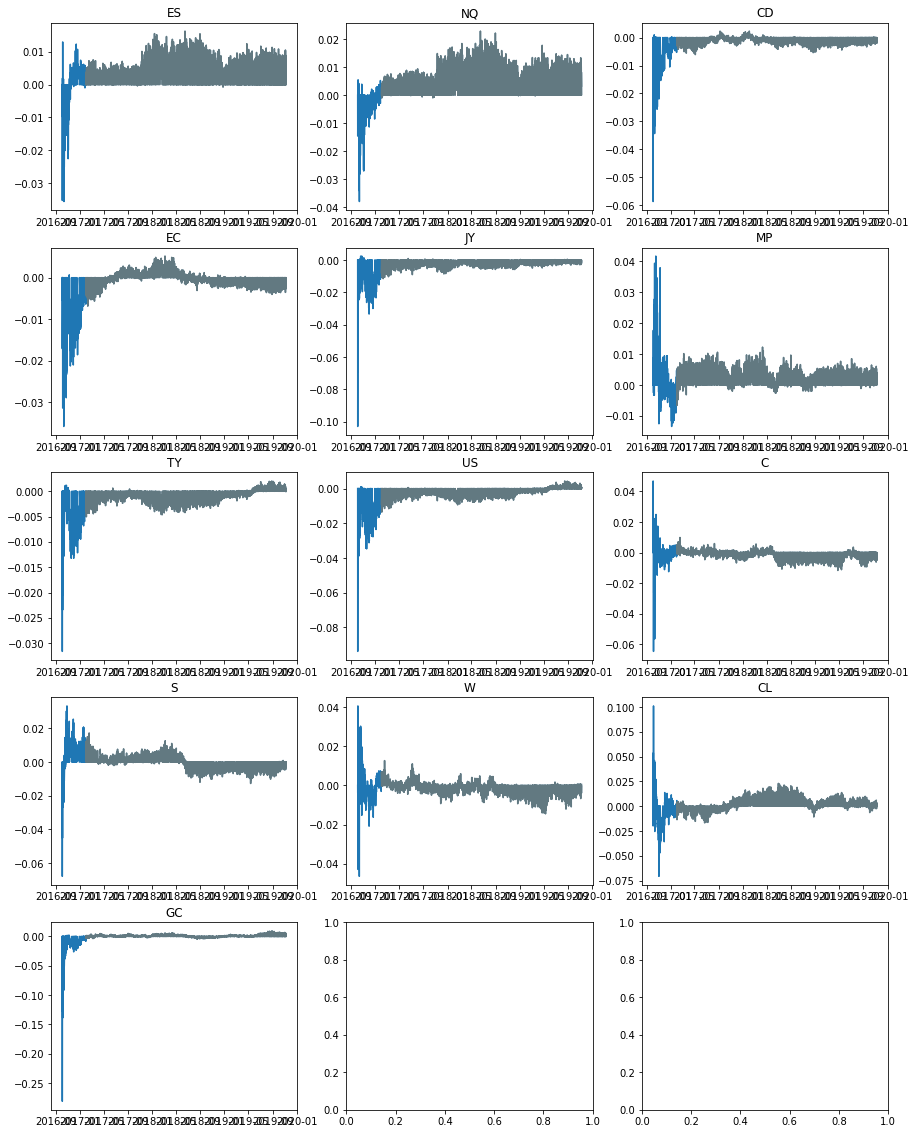

In [71]:
fig, ax = plt.subplots(5,3, figsize=(15,20))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(daily_tweets['{}_single_ret'.format(inst)])
    ax[i].plot(daily_tweets[daily_tweets.after4_date >= 
                            pd.to_datetime('2017-02-01')]['{}_single_ret'.format(inst)], alpha =0.3)
    ax[i].set_title(inst)

In [72]:
final_daily_tweets = daily_tweets[daily_tweets.after4_date >= pd.to_datetime('2017-02-01')]

Calculating the 3 features:

- **daily_tweet_score**: The average of the scores for every word tweeted in a day.
- **max_tweet_score**: The score of the tweet with the highest score in a day.
- **min_tweet_score**: The score of the tweet with the highest score in a day.

In [16]:
tweet_returns_features = pd.DataFrame()
for inst in instrument_list:
    final_nozero = final_daily_tweets[final_daily_tweets[inst+'_single_ret']!=0]
    tweet_returns_features[inst + '_min_tweet'] = final_nozero.groupby('after4_date').min()[inst+'_single_ret']
    tweet_returns_features[inst + '_max_tweet'] = final_nozero.groupby('after4_date').max()[inst+'_single_ret']
    tweet_returns_features[inst + '_daily_tweet'] = daily_df[inst + '_daily_tweet_score']

In [73]:
tweet_returns_features.head()

,ES_min_tweet,ES_max_tweet,ES_daily_tweet,NQ_min_tweet,NQ_max_tweet,NQ_daily_tweet,CD_min_tweet,CD_max_tweet,CD_daily_tweet,EC_min_tweet,...,S_daily_tweet,W_min_tweet,W_max_tweet,W_daily_tweet,CL_min_tweet,CL_max_tweet,CL_daily_tweet,GC_min_tweet,GC_max_tweet,GC_daily_tweet
date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,0.001327,0.003084,0.000105,0.000571,0.002905,0.000071,-0.002969,-0.002929,-0.000105,-0.003917,...,0.000400,0.003273,0.006890,0.000192,-0.013598,-0.001480,-0.000215,-0.002968,-0.001088,-0.000081
2017-02-02,-0.000004,0.003867,0.000082,-0.001018,0.004204,0.000053,-0.002580,-0.000271,-0.000073,-0.004450,...,0.000353,0.000942,0.005608,0.000144,-0.005371,0.004203,-0.000064,-0.003318,0.001656,-0.000050
2017-02-03,0.001319,0.005195,0.000133,0.000611,0.002715,0.000086,-0.002934,-0.001324,-0.000093,-0.003618,...,0.000261,-0.000125,0.003374,0.000048,-0.007231,0.003012,-0.000076,-0.002461,-0.000722,-0.000068
2017-02-06,0.001328,0.003935,0.000133,-0.000043,0.002914,0.000077,-0.002640,-0.001264,-0.000093,-0.003573,...,0.000301,-0.000476,0.001679,0.000018,-0.004039,0.004057,-0.000061,-0.002233,0.000442,-0.000043
2017-02-07,0.001821,0.004572,0.000141,0.001859,0.004924,0.000129,-0.004049,-0.001546,-0.000128,-0.004124,...,0.000428,0.001638,0.004803,0.000130,-0.008617,-0.002315,-0.000212,-0.000658,0.001226,-0.000010


In [74]:
tweet_returns_features.index.name = 'date'
tweet_returns_features.to_csv('../data/features/tweet_returns.csv')

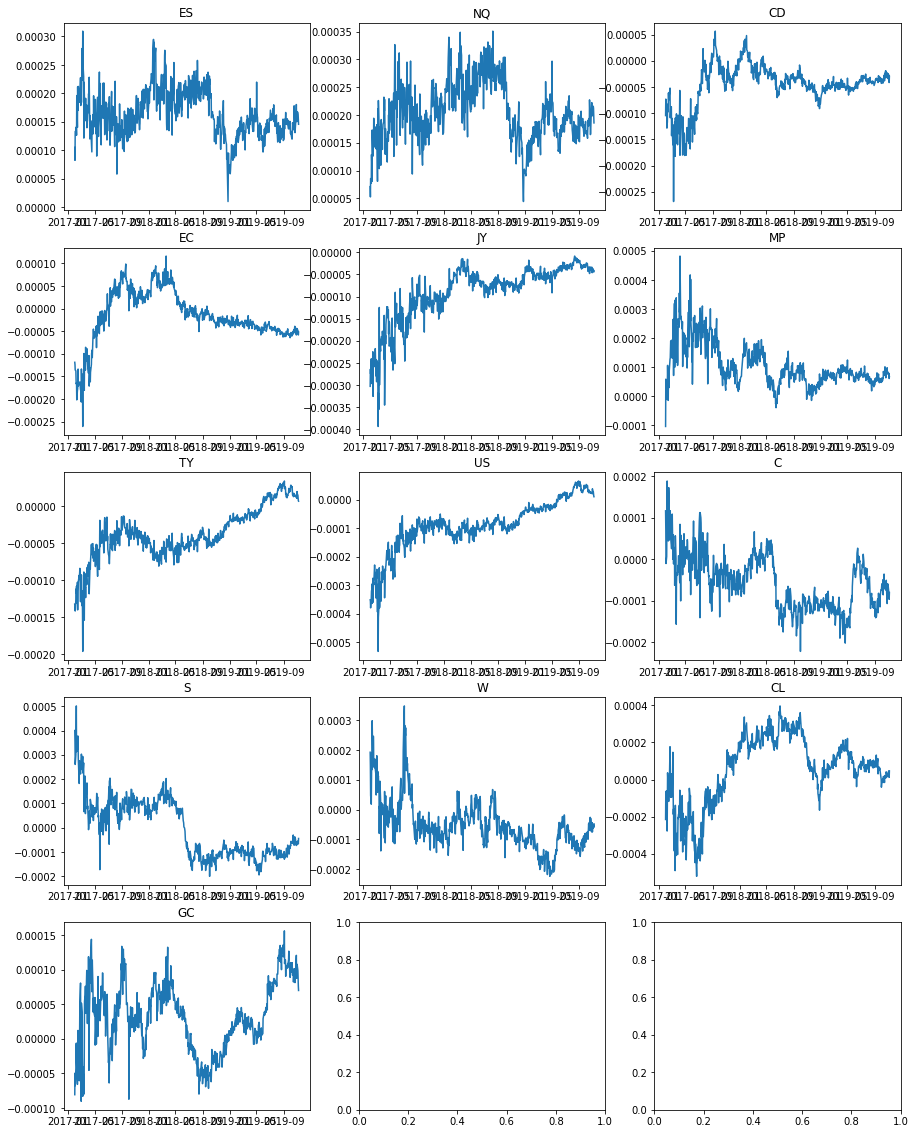

In [75]:
fig, ax = plt.subplots(5,3, figsize=(15,20))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(tweet_returns_features['{}_daily_tweet'.format(inst)])
    ax[i].set_title(inst)

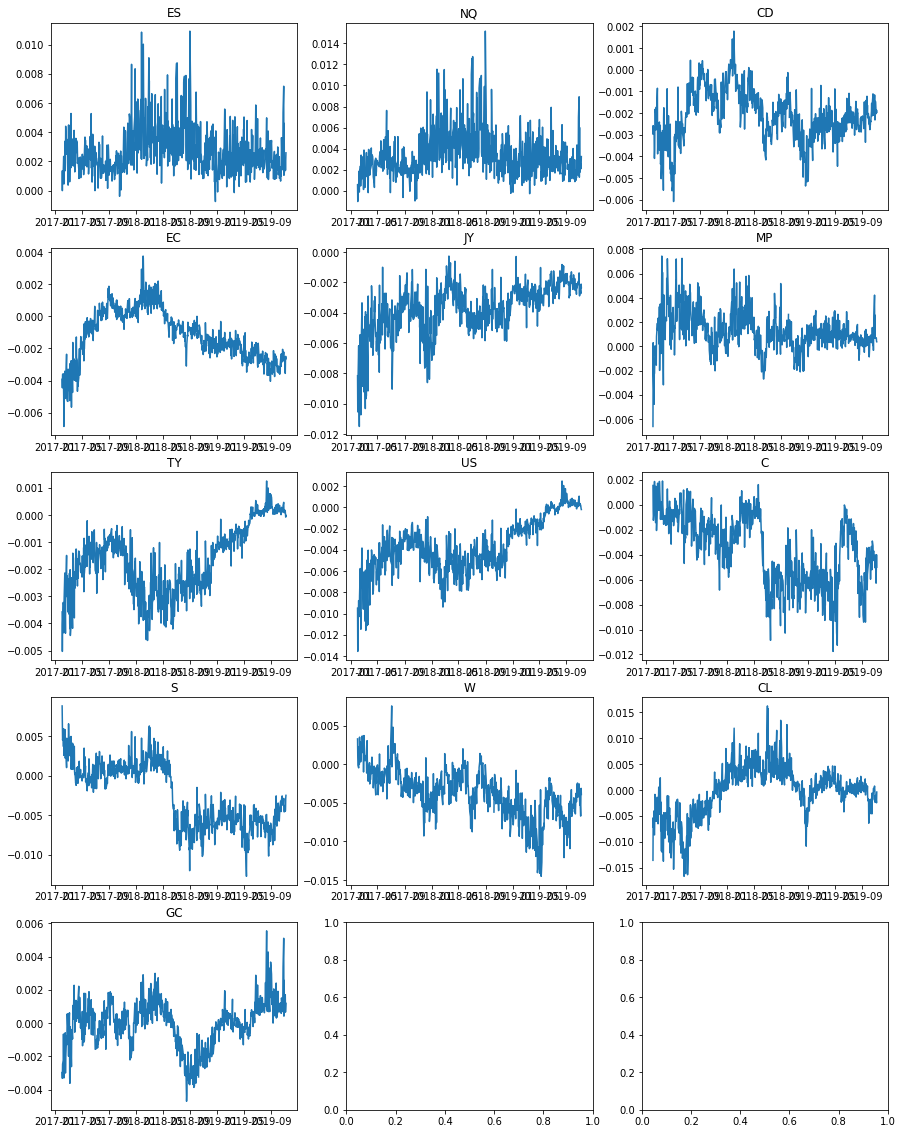

In [76]:
fig, ax = plt.subplots(5,3, figsize=(15,20))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(tweet_returns_features['{}_min_tweet'.format(inst)])
    ax[i].set_title(inst)

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(15,20))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(tweet_returns_features['{}_max_tweet'.format(inst)])
    ax[i].set_title(inst)